In [1]:
from requests import get
from lxml import html

UNIBUC_LAW_LINK = "https://drept.unibuc.ro"
UNIBUC_LAW_BACHELORS_LINK = f"{UNIBUC_LAW_LINK}/Examen-de-licenta-s31-ro.htm"

content = get(UNIBUC_LAW_BACHELORS_LINK).content
html_document = html.fromstring(content)
all_links = html_document.xpath('//a')

In [2]:
SEARCHED_TEXTS = ["Sesiunea iulie", "Sesiunea iunie"]
links_to_exam_pages = {}

for link in all_links:
    if link.text is None:
        continue
        
    if not any([text in link.text for text in SEARCHED_TEXTS]):
        continue
        
    year = link.text[-4:]
    links_to_exam_pages[year] = UNIBUC_LAW_LINK + '/' + link.get('href')
    
links_to_exam_pages

{'2023': 'https://drept.unibuc.ro/Sesiunea-iunie-2023-s1263-ro.htm',
 '2022': 'https://drept.unibuc.ro/Sesiunea-iunie-2022-s1189-ro.htm',
 '2021': 'https://drept.unibuc.ro/Sesiunea-iunie-2021-s1008-ro.htm',
 '2020': 'https://drept.unibuc.ro/Sesiunea-iulie-2020-s918-ro.htm',
 '2019': 'https://drept.unibuc.ro/Sesiunea-iunie-2019-s809-ro.htm',
 '2018': 'https://drept.unibuc.ro/Sesiunea-iunie-2018-s743-ro.htm',
 '2017': 'https://drept.unibuc.ro/Sesiunea-iunie-2017-s696-ro.htm',
 '2016': 'https://drept.unibuc.ro/Sesiunea-iunie-2016-s620-ro.htm',
 '2015': 'https://drept.unibuc.ro/Sesiunea-iunie-2015-s585-ro.htm',
 '2014': 'https://drept.unibuc.ro/Sesiunea-iunie-2014-s426-ro.htm',
 '2013': 'https://drept.unibuc.ro/Sesiunea-iunie-2013-s368-ro.htm',
 '2012': 'https://drept.unibuc.ro/Sesiunea-iunie-2012-s311-ro.htm',
 '2011': 'https://drept.unibuc.ro/Sesiunea-iunie-2011-s272-ro.htm'}

In [3]:
import os

if not os.path.isdir('pdfs'):
    os.mkdir('pdfs')

for year, link in links_to_exam_pages.items():
    exam_page_content = get(link).content
    exam_page_document = html.fromstring(exam_page_content)
    all_links = exam_page_document.xpath('//a')
    
    for link in all_links:
        if link.text is None:
            continue
        
        link_text = link.text.lower().replace('ț', 't').replace('ţ', 't')
        
        if 'promovati' not in link_text:
            continue
            
        category = 'nepromovati' if 'nepromovati' in link_text else 'promovati'
    
        print(f"Downloading results for year {year} and category {category}...")
            
        pdf_content = get(link.get('href')).content
        with open(f"pdfs/{year}_{category}.pdf", "wb") as pdf_file:
            pdf_file.write(pdf_content)
    
os.listdir('pdfs')

['2011_promovati.pdf',
 '2022_nepromovati.pdf',
 '2021_nepromovati.pdf',
 '2016_nepromovati.pdf',
 '2016_promovati.pdf',
 '2012_promovati.pdf',
 '2013_nepromovati.pdf',
 '2022_promovati.pdf',
 '2012_nepromovati.pdf',
 '2021_promovati.pdf',
 '2017_promovati.pdf',
 '2020_promovati.pdf',
 '2013_promovati.pdf',
 '2011_nepromovati.pdf',
 '2014_nepromovati.pdf',
 '2023_nepromovati.pdf',
 '2017_nepromovati.pdf',
 '2014_promovati.pdf',
 '2020_nepromovati.pdf',
 '2019_promovati.pdf',
 '2023_promovati.pdf']

In [22]:
!pip install camelot-py ghostscript

In [35]:
import camelot
import warnings

warnings.simplefilter('ignore')

tables = {}

for year in range(2010, 2030):    
    if not os.path.exists(f'pdfs/{year}_promovati.pdf') or not os.path.exists(f'pdfs/{year}_nepromovati.pdf'):
        continue
    
    print(f"Reading files for year {year}...")
    try:
        promovati_tables = camelot.read_pdf(f'pdfs/{year}_promovati.pdf', pages='all', suppress_stdout=True)
        nepromovati_tables = camelot.read_pdf(f'pdfs/{year}_nepromovati.pdf', pages='all', suppress_stdout=True)
    except Exception as error:
        print(f"We got some error for year {year}:", error)
        continue
        
    if len(promovati_tables) == 0 or len(nepromovati_tables) == 0:
        continue

    tables[year] = (promovati_tables, nepromovati_tables)

Reading files for year 2011...
Reading files for year 2012...
Reading files for year 2013...
Reading files for year 2014...
Reading files for year 2016...
Reading files for year 2017...
We got some error for year 2017: Stream has ended unexpectedly
Reading files for year 2020...
Reading files for year 2021...
Reading files for year 2022...
Reading files for year 2023...


In [43]:
tables[2023][0][0].df[:5]

,0,1,2,3
0,Nr. \nCrt.,Nr. \nLeg.,Numele şi Prenume,Nota
1,1,,abhihajnnc,8.30
2,2,,adlt7sssft,8.00
3,3,,ajfrorzhor,8.50
4,4,,ajhxwwnyzi,6.90


In [71]:
from pandas import DataFrame

final_table = {"grades": [], "year": []}

for year, (promovati_tables, nepromovati_tables) in tables.items():
    
    grades = []
    
    for table in promovati_tables:
        only_numbers = table.df[table.df[3].str.contains('\\d+\.\\d+', regex=True)][3].astype(float)
        grades.extend(only_numbers)
        
    for table in nepromovati_tables:
        only_numbers = table.df[table.df[3].str.contains('\\d+\.\\d+', regex=True)][3].astype(float)
        grades.extend(only_numbers)
        
    final_table['grades'].extend(grades)
    for _ in range(len(grades)):
        final_table['year'].append(int(year))
        
final_df = DataFrame(final_table)

In [91]:
for name, group in final_df.groupby('year'):
    print(f"Year = {name} Mean = {group['grades'].mean():.2f} Median = {group['grades'].median()}")

Year = 2020 Mean = 7.02 Median = 7.1
Year = 2021 Mean = 7.36 Median = 7.5
Year = 2022 Mean = 7.40 Median = 7.5
Year = 2023 Mean = 6.90 Median = 6.9


array([<Axes: title={'center': 'grades'}>], dtype=object)

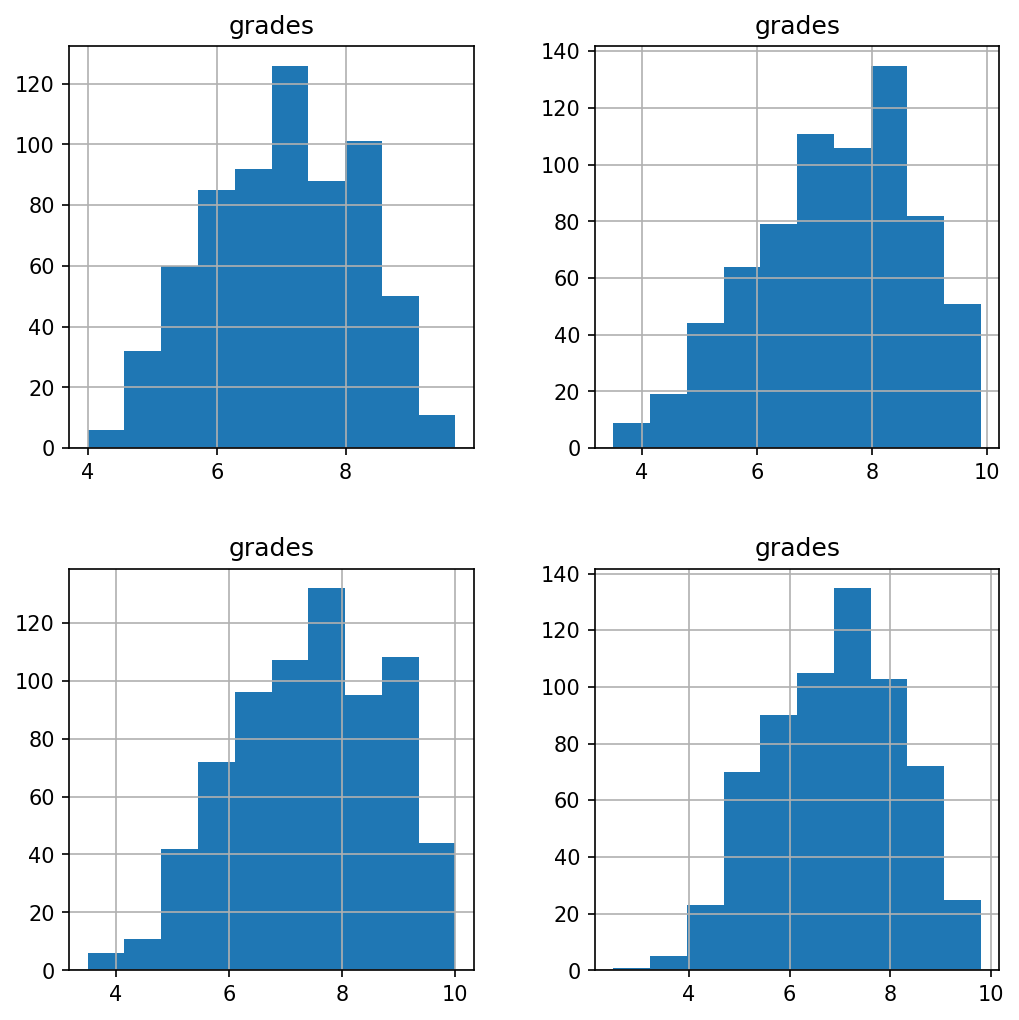

In [104]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(dpi=150, nrows=2, ncols=2, figsize=(8, 8))

final_df.groupby('year').get_group(2020).hist('grades', ax=axes[0,0])
final_df.groupby('year').get_group(2021).hist('grades', ax=axes[0,1])
final_df.groupby('year').get_group(2022).hist('grades', ax=axes[1,0])
final_df.groupby('year').get_group(2023).hist('grades', ax=axes[1,1])

array([[<Axes: title={'center': '2020'}>,
        <Axes: title={'center': '2021'}>],
       [<Axes: title={'center': '2022'}>,
        <Axes: title={'center': '2023'}>]], dtype=object)

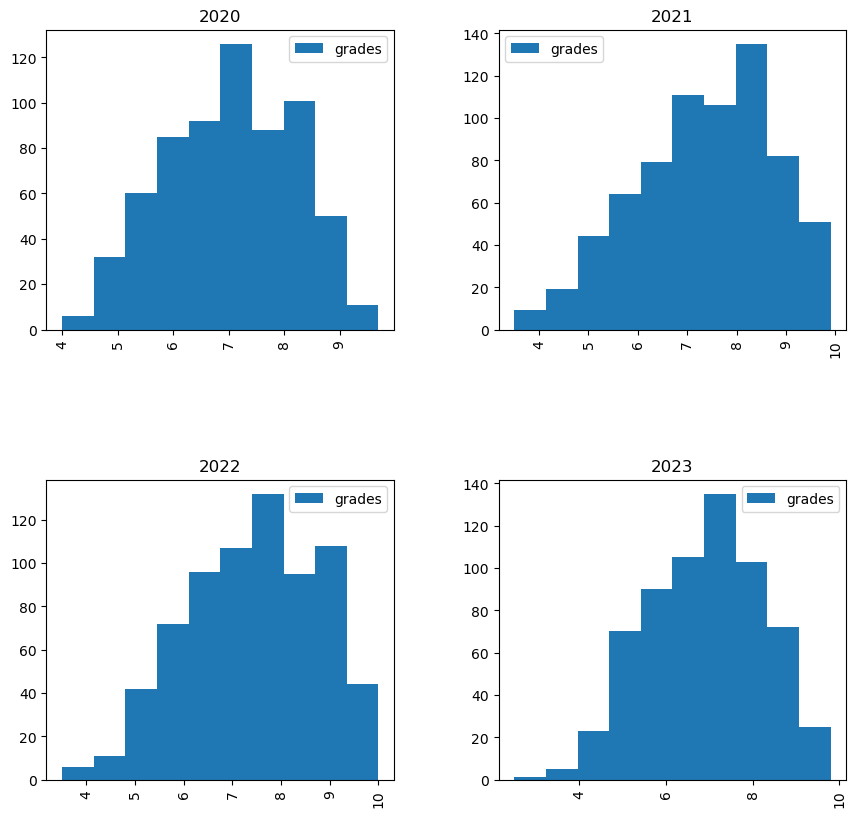

In [114]:
final_df.hist(column='grades', by='year', legend=True, figsize=(10, 10))

In [127]:
for year, group in final_df.groupby('year'):
    print(f"An = {year}")
    print(f"Medie = {group['grades'].mean():.2f} Mediana = {group['grades'].median():.2f}")
    for grade in range(3, 10 + 1):
        percent = group.loc[group['grades'] < grade,'grades'].count() / group['grades'].count() * 100
        print(f"Note < {grade}: {percent:.2f}%")
    
    print()

An = 2020
Medie = 7.02 Mediana = 7.10
Note < 3: 0.00%
Note < 4: 0.00%
Note < 5: 3.84%
Note < 6: 20.28%
Note < 7: 45.93%
Note < 8: 75.12%
Note < 9: 96.93%
Note < 10: 100.00%

An = 2021
Medie = 7.36 Mediana = 7.50
Note < 3: 0.00%
Note < 4: 0.71%
Note < 5: 4.71%
Note < 6: 17.14%
Note < 7: 35.57%
Note < 8: 61.71%
Note < 9: 87.43%
Note < 10: 100.00%

An = 2022
Medie = 7.40 Mediana = 7.50
Note < 3: 0.00%
Note < 4: 0.70%
Note < 5: 3.79%
Note < 6: 16.13%
Note < 7: 37.31%
Note < 8: 63.81%
Note < 9: 85.97%
Note < 10: 99.72%

An = 2023
Medie = 6.90 Mediana = 6.90
Note < 3: 0.16%
Note < 4: 0.95%
Note < 5: 7.79%
Note < 6: 26.71%
Note < 7: 50.08%
Note < 8: 75.68%
Note < 9: 94.59%
Note < 10: 100.00%

